In [1]:
from copy import deepcopy
from pathlib import Path
import pickle
from typing import Literal

from gears import PertData
import seaborn as sns
from sklearn.linear_model import ElasticNet
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/home/users/geroldcsendes/miniconda3/envs/scgpt_yml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


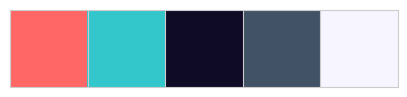

In [2]:
sns.set_style("whitegrid")
colors = ['#FF6666', '#33C7CC', '#0F0A26', '#425266', '#F7F5FF']
sns.set_palette(sns.color_palette(colors))
sns.palplot(sns.color_palette(colors))

In [7]:
def _filt_self_from_de(pert_data, is_norman: bool):

    DE_COL = "rank_genes_groups_cov_all"  # top_non_dropout_de_20

    gene_name_to_ensg = dict(zip(pert_data.adata.var["gene_name"], pert_data.adata.var.index))
    rank_genes_groups_cov_all = deepcopy(pert_data.adata.uns[DE_COL])

    updated_rank_genes_groups_cov_all = {}

    for k, v in rank_genes_groups_cov_all.items():
        condition = k.split("_")[1]
        condition_gene_name = condition.replace("ctrl+", "").replace("+ctrl", "")

        if is_norman:
            condition_ensg_name = gene_name_to_ensg.get(condition_gene_name, None)
            updated_rank_genes_groups_cov_all[k] = v[v != condition_ensg_name]
        else:
            if "+" in condition_gene_name:
                condition_gene_name = condition_gene_name.split("+")
                assert len(condition_gene_name) == 2
                condition_ensg_name = [gene_name_to_ensg.get(g, None) for g in condition_gene_name]
                mask = ~np.isin(v, condition_ensg_name)
                updated_rank_genes_groups_cov_all[k] = v[mask]
            else:
                condition_ensg_name = gene_name_to_ensg.get(condition_gene_name, None)
                updated_rank_genes_groups_cov_all[k] = v[v != condition_ensg_name]
    
    return updated_rank_genes_groups_cov_all


def eval(pred: np.ndarray, data: dict, pert_data: PertData, is_norman: bool, key_pattern: str):

    DE_COL = "rank_genes_groups_cov_all"  # top_non_dropout_de_20
    de_dict =  pert_data.adata.uns[DE_COL]
    de_dict_noself = _filt_self_from_de(pert_data, is_norman)

    ctrl = data['ctrl_mean']
    assert pred.shape[1] == ctrl.shape[0]

    cols = data['test_y'].columns

    pearson_raw = []
    pearson_delta = []
    pearson_delta_de = []
    pearson_delta_de_no_knockout = []

    for i in range(pred.shape[0]):
        _pred = pred[i]
        _target_df = data['test_y'].iloc[i]
        _target = data['test_y'].iloc[i].values

        pearson_raw.append(pearsonr(_pred, _target)[0])
        pearson_delta.append(pearsonr(_pred - ctrl, _target - ctrl)[0])

        de = de_dict[key_pattern % _target_df.name][:20]
        de_pred_indices = np.array([idx for idx, i in enumerate(cols) if i in de])

        # de_pred_indices = np.argsort(_target)[::-1][:20]
        # de = cols[de_pred_indices]
        # print(f"{de=}")

        de_no_self = de_dict_noself[key_pattern % _target_df.name][:20]
        de_no_self_pred_indices = [idx for idx, i in enumerate(cols) if i in de_no_self]

        sum_de = _target_df[de].sum()
        # get top20 of target
        top20 = np.sort(_target)[::-1][:20]
        sum_de_data = np.sum(top20)

        print(f"{sum_de=}, {sum_de_data=}")
        print(ctrl)
        print(ctrl[de_pred_indices])

        pearson_delta_de.append(
            pearsonr(_pred[de_pred_indices] - ctrl[de_pred_indices], _target_df[de] - ctrl[de_pred_indices])[0]
        )
        pearson_delta_de_no_knockout.append(
            pearsonr(_pred[de_no_self_pred_indices] -ctrl[de_no_self_pred_indices] , _target_df[de_no_self] - ctrl[de_no_self_pred_indices])[0]
        )

    return dict(
        pearson=np.mean(pearson_raw),
        pearson_delta=np.mean(pearson_delta),
        pearson_de_delta=np.mean(pearson_delta_de),
        pearson_delta_de_no_knockout=np.mean(pearson_delta_de_no_knockout))

In [8]:
def _get_go_features(is_norman: bool, perturbation_list: list, go_pca: pd.DataFrame):

    GO_NULL_STR = "NULL"
    go_pca = go_pca.copy()
    pert_list = [i.replace("ctrl+", "").replace("+ctrl", "") for i in perturbation_list]
    if is_norman:
        # insert NULL as a row to the go_pca with 0 values
        go_pca.loc[GO_NULL_STR] = 0

        pert1 = []
        pert2 = []
        for i in pert_list:
            if '+' in i:
                p1, p2 = i.split('+')
                pert1.append(p1)
                pert2.append(p2)
            else:
                pert1.append(i)
                pert2.append('NULL')
        
        go_features = go_pca.loc[pert1].values - go_pca.loc[pert2].values

    else:
        go_features = go_pca.loc[pert_list]
    return go_features

def create_bulk_data(pert_data, go_pca_, is_norman: bool):

    data_splits = deepcopy(pert_data.set2conditions)

    train_samples = data_splits['train'] + data_splits['val']
    train_samples.remove('ctrl')
    test_samples = data_splits['test']

    assert 'ctrl' not in test_samples, "ctrl in test samples"

    data = pert_data.adata.to_df()
    data['condition'] = pert_data.adata.obs['condition']
    data = data.groupby('condition').mean()

    train_x = _get_go_features(is_norman, train_samples, go_pca_)
    train_y = data.loc[train_samples].copy()
    test_x = _get_go_features(is_norman, test_samples, go_pca_)
    test_y = data.loc[test_samples].copy()
    ctrl_mean = data.loc['ctrl'].values

    assert train_x.shape[0] == train_y.shape[0], "Train shapes do not match"
    assert test_x.shape[0] == test_y.shape[0], "Test shapes do not match"
    assert train_x.shape[1] == test_x.shape[1], "Train and test features do not match"
    assert train_y.shape[1] == test_y.shape[1], "Train and test targets do not match"
    assert ctrl_mean.shape[0] == train_y.shape[1] == test_y.shape[1], "ctrl mean shape does not match"
    assert ctrl_mean.ndim == 1, "ctrl mean is not 1D"

    print("Number of training samples: ", train_x.shape[0])
    print("Number of test samples: ", test_x.shape[0])

    return dict(
        train_x=train_x,
        train_y=train_y,
        test_x=test_x,
        test_y=test_y,
        ctrl_mean=ctrl_mean,
    )

In [9]:
go = pd.read_csv("../data/go_v1.csv", index_col=0)

pca_256 = PCA(n_components=256, random_state=0)
go_pca = pca_256.fit_transform(go)
go_pca = pd.DataFrame(go_pca, index=go.index)

## Adamson

In [10]:
pert_data_adamson = PertData("../data/")
pert_data_adamson.load(data_name='adamson')
pert_data_adamson.prepare_split(split="simulation", seed=1)

Found local copy...


Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:22
Done!


In [11]:
adamson_data = create_bulk_data(
    pert_data=pert_data_adamson,
    go_pca_=go_pca,
    is_norman=False,
)

Number of training samples:  64
Number of test samples:  22


In [12]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, verbose=True)
rf.fit(adamson_data['train_x'], adamson_data['train_y'])
adamson_pred = rf.predict(adamson_data['test_x'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


In [13]:
adamson_res = eval(
    pred=adamson_pred,
    data=adamson_data,
    pert_data=pert_data_adamson,
    is_norman=False,
    key_pattern="K562(?)_%s_1+1",
)

sum_de=60.70836, sum_de_data=90.97499
[4.8381169e-04 1.3159742e-04 3.5870657e-03 ... 3.0072461e-04 1.5817435e-01
 2.0248252e-01]
[4.4880157  3.236339   3.360331   3.5821466  4.904097   3.3841681
 5.2182107  2.8832545  4.52302    2.19916    0.17053933 0.9268563
 4.0518727  0.9734968  5.092592   1.0086207  0.92883646 2.446178
 4.021572   3.9770062 ]
sum_de=51.952065, sum_de_data=90.788895
[4.8381169e-04 1.3159742e-04 3.5870657e-03 ... 3.0072461e-04 1.5817435e-01
 2.0248252e-01]
[4.4880157  1.8144168  3.236339   0.64417243 3.360331   0.5043853
 4.904097   3.3841681  2.8832545  4.52302    2.19916    0.9268563
 4.0518727  0.9734968  5.092592   1.0086207  0.92883646 2.446178
 4.021572   3.9770062 ]
sum_de=53.055496, sum_de_data=86.98147
[4.8381169e-04 1.3159742e-04 3.5870657e-03 ... 3.0072461e-04 1.5817435e-01
 2.0248252e-01]
[3.236339  1.9909401 3.360331  4.155709  3.3841681 1.7533067 4.52302
 1.6235821 1.3985678 2.566253  1.7857326 2.218012  1.1914971 2.9013004
 1.9150076 0.6164367 2.93074

In [34]:
adamson_pred.shape

(22, 5060)

In [41]:
mean_pred = adamson_data["train_y"].mean().values.reshape(1, -1)
mean_pred = np.repeat(mean_pred, adamson_pred.shape[0], axis=0)

mean_pred.shape

(22, 5060)

In [43]:
adamson_res_mean = eval(
    pred=mean_pred,
    data=adamson_data,
    pert_data=pert_data_adamson,
    is_norman=False,
    key_pattern="K562(?)_%s_1+1",
)

sum_de=60.70836, sum_de_data=90.97499
[4.8381169e-04 1.3159742e-04 3.5870657e-03 ... 3.0072461e-04 1.5817435e-01
 2.0248252e-01]
[4.4880157  3.236339   3.360331   3.5821466  4.904097   3.3841681
 5.2182107  2.8832545  4.52302    2.19916    0.17053933 0.9268563
 4.0518727  0.9734968  5.092592   1.0086207  0.92883646 2.446178
 4.021572   3.9770062 ]
sum_de=51.952065, sum_de_data=90.788895
[4.8381169e-04 1.3159742e-04 3.5870657e-03 ... 3.0072461e-04 1.5817435e-01
 2.0248252e-01]
[4.4880157  1.8144168  3.236339   0.64417243 3.360331   0.5043853
 4.904097   3.3841681  2.8832545  4.52302    2.19916    0.9268563
 4.0518727  0.9734968  5.092592   1.0086207  0.92883646 2.446178
 4.021572   3.9770062 ]
sum_de=53.055496, sum_de_data=86.98147
[4.8381169e-04 1.3159742e-04 3.5870657e-03 ... 3.0072461e-04 1.5817435e-01
 2.0248252e-01]
[3.236339  1.9909401 3.360331  4.155709  3.3841681 1.7533067 4.52302
 1.6235821 1.3985678 2.566253  1.7857326 2.218012  1.1914971 2.9013004
 1.9150076 0.6164367 2.93074

In [44]:
adamson_res_mean

{'pearson': 0.9925119581924874,
 'pearson_delta': 0.7083888248191635,
 'pearson_de_delta': 0.2881941160655763,
 'pearson_delta_de_no_knockout': 0.3295554624917052}

In [14]:
adamson_pred

array([[4.70717384e-04, 3.29490305e-05, 4.89336054e-03, ...,
        7.32025763e-04, 1.91172327e-01, 2.22118062e-01],
       [5.62474630e-04, 3.50269904e-05, 6.24249486e-03, ...,
        9.14468005e-04, 2.20385010e-01, 2.77481528e-01],
       [7.34620912e-04, 6.63518952e-05, 6.05881337e-03, ...,
        9.69705898e-04, 2.17495307e-01, 2.74943588e-01],
       ...,
       [3.51699988e-04, 5.34660070e-05, 6.95354413e-03, ...,
        8.54737843e-04, 2.18225913e-01, 2.72670417e-01],
       [3.56811545e-04, 5.85295955e-05, 5.95800802e-03, ...,
        8.29315309e-04, 2.09445924e-01, 2.62128290e-01],
       [3.84705652e-04, 2.30487708e-06, 7.28793107e-03, ...,
        6.32595348e-04, 2.20185315e-01, 2.85471703e-01]])

In [15]:
pert_data = pert_data_adamson
is_norman = False
data = adamson_data
pred = adamson_pred
key_pattern = "K562(?)_%s_1+1"


In [16]:
DE_COL = "rank_genes_groups_cov_all"  # top_non_dropout_de_20
de_dict =  pert_data.adata.uns[DE_COL]
de_dict_noself = _filt_self_from_de(pert_data, is_norman)

ctrl = data['ctrl_mean']
assert pred.shape[1] == ctrl.shape[0]

cols = data['test_y'].columns

pearson_raw = []
pearson_delta = []
pearson_delta_de = []
pearson_delta_de_no_knockout = []

In [17]:
ctrl

array([4.8381169e-04, 1.3159742e-04, 3.5870657e-03, ..., 3.0072461e-04,
       1.5817435e-01, 2.0248252e-01], dtype=float32)

In [18]:
ctrl.shape

(5060,)

In [24]:
for i in range(pred.shape[0]):
    _pred = pred[i]
    _target_df = data['test_y'].iloc[i]
    _target = data['test_y'].iloc[i].values

    pearson_raw.append(pearsonr(_pred, _target)[0])
    pearson_delta.append(pearsonr(_pred - ctrl, _target - ctrl)[0])

    de = de_dict[key_pattern % _target_df.name][:20]
    de_pred_indices = np.array([idx for idx, i in enumerate(cols) if i in de])

    # de_pred_indices = np.argsort(_target)[::-1][:20]
    # de = cols[de_pred_indices]

    de_no_self = de_dict_noself[key_pattern % _target_df.name][:20]
    de_no_self_pred_indices = [idx for idx, i in enumerate(cols) if i in de_no_self]

    sum_de = _target_df[de].sum()
    # get top20 of target
    top20 = np.sort(_target)[::-1][:20]
    sum_de_data = np.sum(top20)

    print(f"{sum_de=}, {sum_de_data=}")
    print(ctrl)
    print(ctrl[de_pred_indices])

    pearson_delta_de.append(
        pearsonr(_pred[de_pred_indices] - ctrl[de_pred_indices], _target_df[de] - ctrl[de_pred_indices])[0]
    )
    pearson_delta_de_no_knockout.append(
        pearsonr(_pred[de_no_self_pred_indices] -ctrl[de_no_self_pred_indices] , _target_df[de_no_self] - ctrl[de_no_self_pred_indices])[0]
    )

    break

sum_de=60.70836, sum_de_data=90.97499
[4.8381169e-04 1.3159742e-04 3.5870657e-03 ... 3.0072461e-04 1.5817435e-01
 2.0248252e-01]
[4.4880157  3.236339   3.360331   3.5821466  4.904097   3.3841681
 5.2182107  2.8832545  4.52302    2.19916    0.17053933 0.9268563
 4.0518727  0.9734968  5.092592   1.0086207  0.92883646 2.446178
 4.021572   3.9770062 ]


In [25]:
key_pattern % _target_df.name

'K562(?)_CREB1+ctrl_1+1'

In [26]:
_target_df.name

'CREB1+ctrl'

In [27]:
de

array(['ENSG00000002586', 'ENSG00000169100', 'ENSG00000124614',
       'ENSG00000177954', 'ENSG00000197756', 'ENSG00000168209',
       'ENSG00000108107', 'ENSG00000197976', 'ENSG00000105193',
       'ENSG00000167996', 'ENSG00000112306', 'ENSG00000145592',
       'ENSG00000051108', 'ENSG00000144713', 'ENSG00000175197',
       'ENSG00000142937', 'ENSG00000172809', 'ENSG00000197958',
       'ENSG00000231500', 'ENSG00000187514'], dtype=object)

In [28]:
de_pred_indices

array([ 162,  355,  910,  938,  978, 1481, 1815, 1822, 1929, 2195, 2196,
       2197, 2644, 2791, 2998, 3300, 3986, 4314, 4742, 4853])

<Axes: >

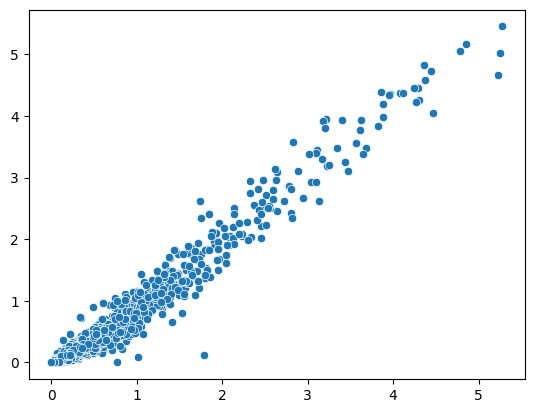

In [68]:
sns.scatterplot(x=_pred, y=_target)

<Axes: >

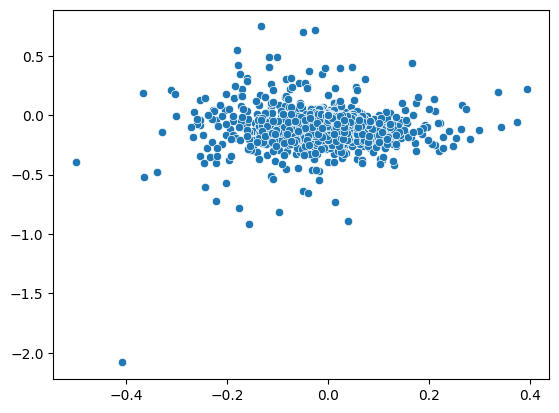

In [67]:
sns.scatterplot(x=_pred - ctrl, y=_target - ctrl)

<Axes: ylabel='CREB1+ctrl'>

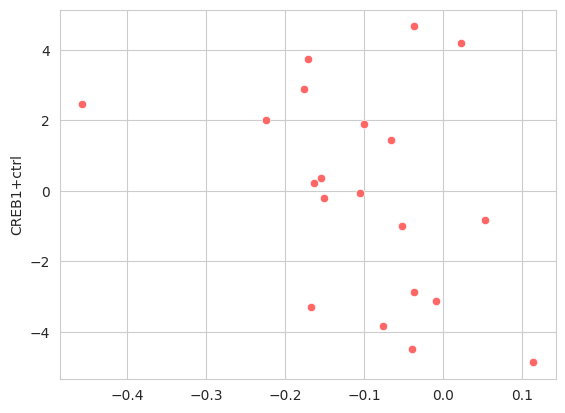

In [30]:
sns.scatterplot(x=_pred[de_pred_indices] - ctrl[de_pred_indices], y=_target_df[de] - ctrl[de_pred_indices])

In [31]:
de_pred_indices = np.argsort(_target)[::-1][:20]
de = cols[de_pred_indices]

<Axes: ylabel='CREB1+ctrl'>

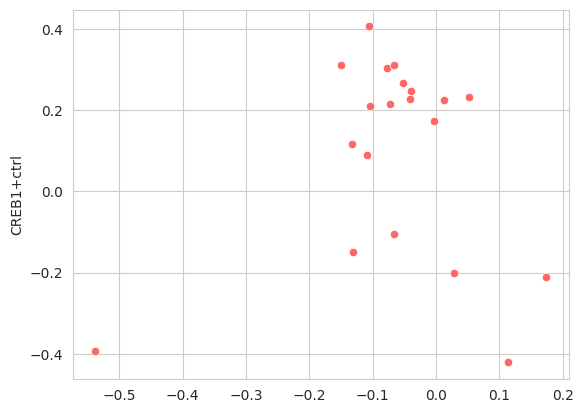

In [32]:
sns.scatterplot(x=_pred[de_pred_indices] - ctrl[de_pred_indices], y=_target_df[de] - ctrl[de_pred_indices])

In [8]:
en = ElasticNet(alpha=1, l1_ratio=0.5)
en.fit(adamson_data['train_x'], adamson_data['train_y'])
adamson_pred_en = en.predict(adamson_data['test_x'])

adamson_res_en = eval(
    pred=adamson_pred_en,
    data=adamson_data,
    pert_data=pert_data_adamson,
    key_pattern="K562(?)_%s_1+1",
    is_norman=False,
) 

sum_de=90.97499, sum_de_data=90.97499
[4.8381169e-04 1.3159742e-04 3.5870657e-03 ... 3.0072461e-04 1.5817435e-01
 2.0248252e-01]
[5.2182107 4.904097  4.82776   5.2164397 4.52302   4.4880157 5.092592
 4.3565073 4.2871304 4.3588977 3.9770062 4.26022   4.155709  4.0518727
 4.021572  4.3717933 4.377006  3.9877048 4.2637167 4.380829 ]
sum_de=90.788895, sum_de_data=90.788895
[4.8381169e-04 1.3159742e-04 3.5870657e-03 ... 3.0072461e-04 1.5817435e-01
 2.0248252e-01]
[5.2182107 4.904097  5.2164397 4.82776   4.52302   4.4880157 5.092592
 4.3565073 4.2871304 4.3588977 4.0518727 3.9770062 4.155709  4.26022
 4.021572  4.3717933 3.9877048 4.377006  4.2637167 3.670373 ]
sum_de=86.98147, sum_de_data=86.98147
[4.8381169e-04 1.3159742e-04 3.5870657e-03 ... 3.0072461e-04 1.5817435e-01
 2.0248252e-01]
[5.2164397 5.092592  5.2182107 4.904097  4.82776   4.2637167 4.3717933
 4.3565073 4.4880157 4.2871304 4.377006  4.3588977 4.52302   4.26022
 3.4561253 4.380829  4.155709  4.021572  3.613325  3.9877048]
sum_d

## Norman

In [13]:
pert_data_norman = PertData("../data/")
pert_data_norman.load(data_path='../data/norman/')
pert_data_norman.prepare_split(split="simulation", seed=1)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Done!


In [14]:
norman_data = create_bulk_data(
    pert_data=pert_data_norman,
    go_pca_=go_pca,
    is_norman=True,
)

Number of training samples:  167
Number of test samples:  116


In [15]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, verbose=True)
rf.fit(norman_data['train_x'], norman_data['train_y'])
norman_pred = rf.predict(norman_data['test_x'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


In [17]:
norman_res = eval(
    pred=norman_pred,
    data=norman_data,
    pert_data=pert_data_norman,
    key_pattern="A549_%s_1+1",
    is_norman=True,
)

sum_de=85.88755, sum_de_data=85.88755
[0.0000000e+00 3.0636375e-03 7.3340833e-03 ... 3.7373199e+00 8.7353901e-04
 0.0000000e+00]
[5.1438856 4.9083667 4.969159  4.8128347 4.5366826 4.5248    4.391857
 4.224815  4.2780695 4.097601  4.391413  4.050415  3.976692  3.940753
 3.9789348 3.942827  3.8272572 4.0983367 3.73732   3.3730962]
sum_de=86.89291, sum_de_data=86.89291
[0.0000000e+00 3.0636375e-03 7.3340833e-03 ... 3.7373199e+00 8.7353901e-04
 0.0000000e+00]
[4.9083667 5.1438856 4.969159  4.8128347 4.391413  4.391857  4.5366826
 4.5248    4.224815  3.940753  3.9789348 4.2780695 3.976692  3.942827
 4.097601  3.8272572 4.050415  4.0983367 3.73732   1.7928959]
sum_de=85.33612, sum_de_data=85.33612
[0.0000000e+00 3.0636375e-03 7.3340833e-03 ... 3.7373199e+00 8.7353901e-04
 0.0000000e+00]
[5.1438856 4.9083667 4.969159  4.8128347 4.391413  4.5366826 4.5248
 4.391857  4.2780695 4.050415  4.224815  4.097601  4.0983367 1.7928959
 3.940753  3.976692  3.8272572 3.73732   3.942827  3.9789348]
sum_de=

In [18]:
en = ElasticNet(alpha=1, l1_ratio=0.5)
en.fit(norman_data['train_x'], norman_data['train_y'])
norman_pred_en = en.predict(norman_data['test_x'])

norman_res_en = eval(
    pred=norman_pred_en,
    data=norman_data,
    pert_data=pert_data_norman,
    key_pattern="A549_%s_1+1",
    is_norman=True,
)

sum_de=85.88755, sum_de_data=85.88755
[0.0000000e+00 3.0636375e-03 7.3340833e-03 ... 3.7373199e+00 8.7353901e-04
 0.0000000e+00]
[5.1438856 4.9083667 4.969159  4.8128347 4.5366826 4.5248    4.391857
 4.224815  4.2780695 4.097601  4.391413  4.050415  3.976692  3.940753
 3.9789348 3.942827  3.8272572 4.0983367 3.73732   3.3730962]
sum_de=86.89291, sum_de_data=86.89291
[0.0000000e+00 3.0636375e-03 7.3340833e-03 ... 3.7373199e+00 8.7353901e-04
 0.0000000e+00]
[4.9083667 5.1438856 4.969159  4.8128347 4.391413  4.391857  4.5366826
 4.5248    4.224815  3.940753  3.9789348 4.2780695 3.976692  3.942827
 4.097601  3.8272572 4.050415  4.0983367 3.73732   1.7928959]
sum_de=85.33612, sum_de_data=85.33612
[0.0000000e+00 3.0636375e-03 7.3340833e-03 ... 3.7373199e+00 8.7353901e-04
 0.0000000e+00]
[5.1438856 4.9083667 4.969159  4.8128347 4.391413  4.5366826 4.5248
 4.391857  4.2780695 4.050415  4.224815  4.097601  4.0983367 1.7928959
 3.940753  3.976692  3.8272572 3.73732   3.942827  3.9789348]
sum_de=

## Replogle

In [19]:
pert_data_replogle = PertData("../data/")
pert_data_replogle.load(data_path='../data/replogle_k562_essential/')
pert_data_replogle.prepare_split(split="simulation", seed=1)

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:273
Done!


In [20]:
replogle_data = create_bulk_data(
    pert_data=pert_data_replogle,
    go_pca_=go_pca,
    is_norman=False,
)

Number of training samples:  819
Number of test samples:  273


In [30]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, verbose=True)
rf.fit(replogle_data['train_x'], replogle_data['train_y'])
replogle_pred = rf.predict(replogle_data['test_x'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.4s finished


In [31]:
replogle_res = eval(
    pred=replogle_pred,
    data=replogle_data,
    pert_data=pert_data_replogle,
    key_pattern="K562(?)_%s_1+1",
    is_norman=False,
)

Mean correlation: 0.49883955611493164


In [21]:
en = ElasticNet(alpha=1, l1_ratio=0.5)
en.fit(replogle_data['train_x'], replogle_data['train_y'])
replogle_pred_en = en.predict(replogle_data['test_x'])

replogle_res_en = eval(
    pred=replogle_pred_en,
    data=replogle_data,
    pert_data=pert_data_replogle,
    key_pattern="K562(?)_%s_1+1",
    is_norman=False,
)

KeyError: 'K562(?)_TIMM9+ctrl_1+1'

In [ ]:
pd.DataFrame(data=dict(
    
))

In [28]:
dataset = ["Adamson"] * 2 + ["Norman"] * 2 + ["Replogle"] * 2
method = ["RF", "ElasticNet"] * 3
metrics = [0.75, 0.708, 0.585, 0.562, 0.494, 0.373]

df = pd.DataFrame(data=dict(
    Dataset=dataset,
    model=method,
    metric=metrics,
))


In [29]:
df

,Dataset,model,metric
0,Adamson,RF,0.750
1,Adamson,ElasticNet,0.708
2,Norman,RF,0.585
3,Norman,ElasticNet,0.562
4,Replogle,RF,0.494
5,Replogle,ElasticNet,0.373


In [33]:
palette = {'RF': '#FF6666', 'ElasticNet': '#33C7CC'}

In [43]:
def myplot (df, dataset):
    palette = {'RF': '#FF6666', 'ElasticNet': '#33C7CC'}
    sns.barplot(data=df[df['Dataset'] == dataset], x='model', y='metric', palette=palette)
    plt.title(f"{dataset} dataset")
    plt.show()

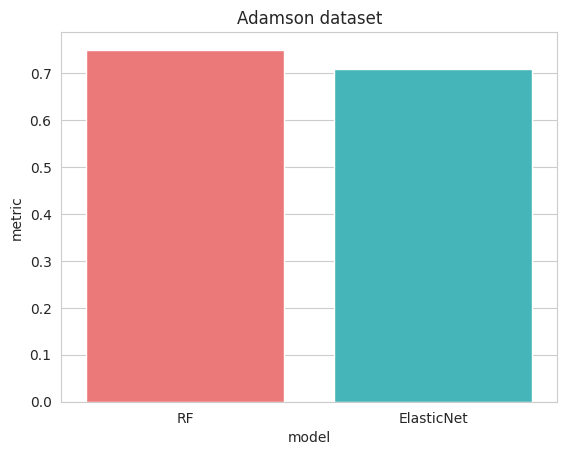

In [44]:
myplot(df, "Adamson")

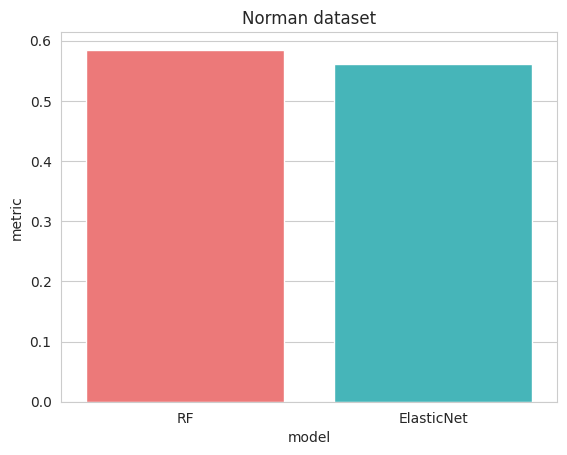

In [45]:
myplot(df, "Norman")

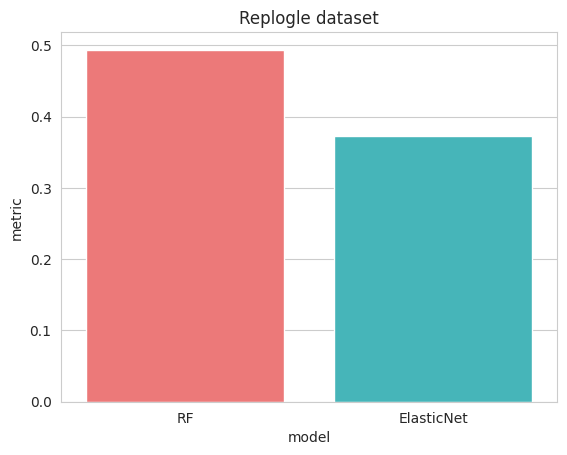

In [46]:
myplot(df, "Replogle")

Text(0.5, 1.0, 'Adamson Pearson Delta Results')

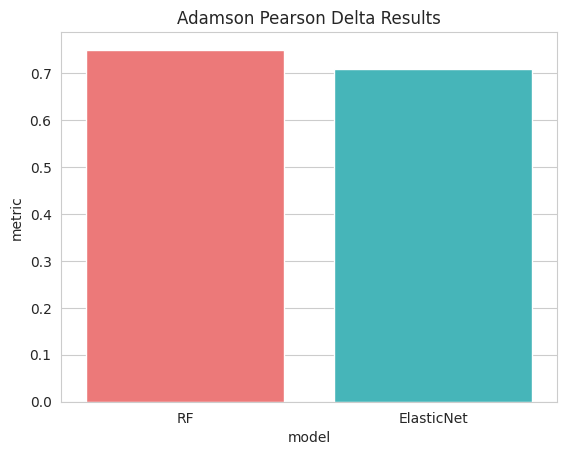

In [38]:
fig, axs = plt.subplots()
sns.barplot(x='model', y='metric', data=df[df.Dataset == "Adamson"], ax=axs, hue='model', palette=palette)
plt.title("Adamson Pearson Delta Results")